In [1]:
import numpy as np 
import pandas as pd
import seaborn as sn 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
APD_FILES = ['COBRA-YTD2017.xlsx', 'COBRA-YTD2016.xlsx']
DATA_PREFIX = "data/"
data = pd.DataFrame() 
for file in APD_FILES: 
    tmp_data = pd.read_excel(DATA_PREFIX + file)
    data = pd.concat((data, tmp_data),axis=0)

In [3]:
#rough map of crime density 
#filter x and y first to remove NaN and Zero 
x = data['x']
y = data['y']

x = x[x != 0]
y = y[y != 0]

x = x.astype('float')
y = y.astype('float')

x = x.values
y = y.values


In [4]:
#Generate 2D Histogram in Numpy 
H, xedges, yedges = np.histogram2d(x, y, bins=500) 

#get centers for x and y 
xc = (xedges[1:] + xedges[:-1])/2 
yc = (yedges[1:] + yedges[:-1])/2 

#Flatten 
entries = np.zeros((xc.shape[0] * yc.shape[0], 3)) 
for i in range(0, xc.shape[0]): 
    for j in range(0, yc.shape[0]): 
        entries[i * yc.shape[0] + j, 1] = xc[i]
        entries[i * yc.shape[0] + j, 0] = yc[j] 
        entries[i * yc.shape[0] + j, 2] = H[i, j]

In [5]:
#Process Entries using a filter 
#we'll take a square of 11x11, and use a normalized sum pool
def apply_sum_filter(x, y, H, FILTER_SIZE = 25): 
    patched = np.zeros((H.shape[0] - FILTER_SIZE, H.shape[1] - FILTER_SIZE)) 
    xr = x[FILTER_SIZE//2:-FILTER_SIZE//2]
    yr = y[FILTER_SIZE//2:-FILTER_SIZE//2]
    #filter 
    for i in range(FILTER_SIZE//2, H.shape[0] - (FILTER_SIZE//2 + 1)): 
        for j in range(FILTER_SIZE//2, H.shape[1] - (FILTER_SIZE//2 + 1)): 
            sumPool = H[i-FILTER_SIZE//2:i+FILTER_SIZE//2 + 1,j-FILTER_SIZE:j+FILTER_SIZE//2 + 1].sum() / (FILTER_SIZE ** 2) 
            patched[i - FILTER_SIZE//2, j - FILTER_SIZE//2] = sumPool
    return (xr, yr, patched)

def apply_gaussian_filter(xc, yc, H, FILTER_SIZE = 25): 
    from scipy.ndimage.filters import gaussian_filter  
    filtered = gaussian_filter(H, FILTER_SIZE) 
    return (xc, yc, filtered) 
R1 = apply_gaussian_filter(xc, yc, H, FILTER_SIZE = 10)

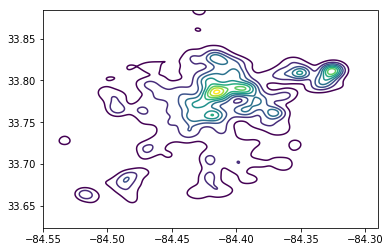

In [6]:
contours = plt.contour(R1[0], R1[1], R1[2], 9)

In [7]:
#generate polygon arrays for each contour 
shapes = {} 
level = 0 
for c in contours.collections: 
    shapes[level] = {'coordinates': []} 
    for path in c.get_paths(): 
        poly = path.to_polygons() 
        coorList = list(map(lambda x: {'lat': x[1], 'lng': x[0]}, poly[0])) 
        shapes[level]['coordinates'].append(coorList) 
    level += 1

In [8]:
import json 
with open("data.js", 'w') as f: 
    s = json.dumps(shapes) 
    f.write("var shapes = " + s) 
